In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt

2023-05-01 23:18:12.452623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
new_dataset_train_path = "../calc_dataset/train/"
new_dataset_val_path = "../calc_dataset/validation/"

In [11]:
train_dataset = pd.read_csv("../dataset/csv/train.csv", index_col=0)
test_dataset = pd.read_csv("../dataset/csv/test.csv", index_col=0)

In [12]:
BATCH_SIZE = 256

tf_train_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                              image_size=(229, 229))

tf_validation_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_val_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                   image_size=(229, 229))

Found 997 files belonging to 2 classes.
Found 36 files belonging to 2 classes.


2023-05-01 23:20:21.235433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [36]
	 [[{{node Placeholder/_4}}]]
2023-05-01 23:20:21.236317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [36]
	 [[{{node Placeholder/_0}}]]


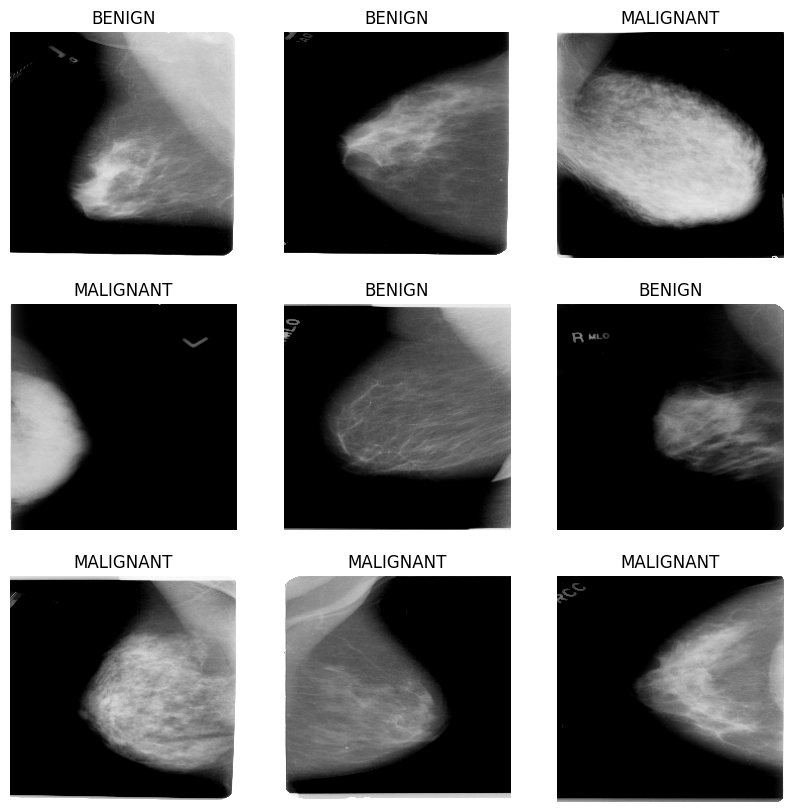

In [13]:
class_names = tf_train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in tf_validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras. layers.RandomFlip("horizontal_and_vertical")])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [15]:
base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(229, 229, 3),  weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
inputs = tf.keras.Input(shape=(229, 229, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs, x)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), metrics=['accuracy'])

In [ ]:
history = model.fit(tf_train_dataset,
                    epochs=100,
                    batch_size=256,
                    validation_data=tf_validation_dataset)

In [17]:
history = model.history

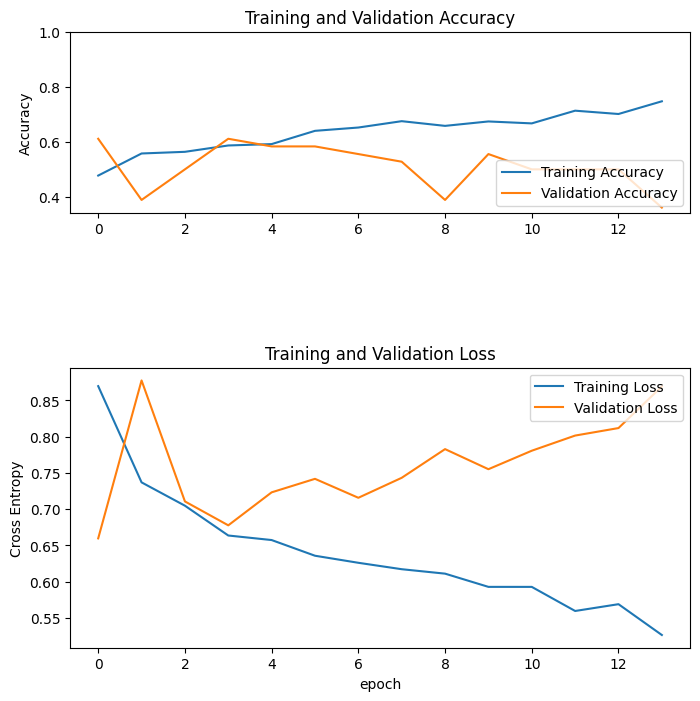

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
images, labels = tf_validation_dataset.as_numpy_iterator().next()

In [20]:
predictions = model.predict(images)

2023-05-01 23:25:29.351962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 2s/step


In [27]:
cf_matrix = tf.math.confusion_matrix(predictions=y_preds, labels=labels,num_classes=2)

In [28]:
cf_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 6,  8],
       [10, 12]], dtype=int32)>

In [24]:
from sklearn.metrics import f1_score

In [25]:
y_preds = [round(pred) for pred in np.squeeze(predictions)]

In [26]:
f1_score(y_true=labels, y_pred=y_preds)

0.5714285714285713